In this notebook, we will use another dataset from Kaggle, the skin cancer dataset of malignant VS benign ([Kaggle link](https://www.kaggle.com/fanconic/skin-cancer-malignant-vs-benign)) as another use case when using a larger curated dataset. This data was obtained from the International Skin Imaging Collaboration (ISIC) organization.

In this notebook, we will use transfer learning, i.e. to make use of models that have been trained on larger and more general datasets (usually the [ImageNet](https://www.image-net.org/about.php) dataset). We use these **pre-trained models** as our foundation and fine-tune it for our custom task. This usually works very well because the models have already learnt to distinguish a lot of different features about our world, so we just train it to focus on our specific task. 

Transfer learning also makes training much faster and usually result in better performance compared to building and training our own model from scratch. Therefore, in most cases, transfer learning is preferred.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time

# most import image processing library, OpenCV as cv2
import cv2
from imutils.paths import list_images

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

In [2]:
# check whether have access to GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Setup config

Almost the same config with the previous "Training - Sign Language" notebook, except for the directories to the training set and testing set, as well as CLASS_NAMES.

In [3]:
# File directory to the training folder.
# Follow the config setup in the image collection notebook, or your own folder,
# consisting of one "training" folder, one "validation" folder, and one "testing" folder
DATASET_DIR = "dataset"

# Setup training and testing paths
# These paths should be changed accordingly
TRAIN_PATH = os.path.join(DATASET_DIR, "skin-cancer-kaggle", "train")
TEST_PATH = os.path.join(DATASET_DIR, "skin-cancer-kaggle", "test")

# Path to model's related components
OUTPUTS_PATH = "outputs"
if not os.path.exists(OUTPUTS_PATH):
    os.makedirs(OUTPUTS_PATH)

# "belign" VS "malignant", but not sure about the order yet
CLASS_NAMES = ["TO BE DEFINED IN train_ds later"]

## Training Config

In [4]:
# initialize the initial learning rate, batch size, and number of
# epochs to train for
INIT_LR = 1e-4
BATCH_SIZE = 32 # Number of training examples used in one iteration of training
NUM_EPOCHS = 10

# NOTE: 224x224 is the original size of the images
IMG_HEIGHT = 224 # height of image to resize to
IMG_WIDTH = 224 # width of image to resize to

In [5]:
from datetime import datetime
# define the path to the serialized output model after training
# you may change the filename to your preferred name
MODEL_PATH = os.path.join(OUTPUTS_PATH, f"skin_cancer_classifier-{datetime.today().date()}.model")

# path to save the classification report of accuracy, precision etc.
CLASSIF_REPORT_PATH = os.path.join(OUTPUTS_PATH, "classification_report.txt")

# path to output loss/accuracy plot
PLOT_PATH = os.path.join(OUTPUTS_PATH, "plot.png")

# Inspecting dataset

In [43]:
from imutils.paths import list_images

benign_train = len(list(list_images(os.path.join(TRAIN_PATH, 'benign'))))
benign_test = len(list(list_images(os.path.join(TEST_PATH, 'benign'))))
benign_images = benign_train + benign_test

malignant_train = len(list(list_images(os.path.join(TRAIN_PATH, 'malignant'))))
malignant_test = len(list(list_images(os.path.join(TEST_PATH, 'malignant'))))
malignant_images = malignant_train + malignant_test

print(f"Train set | benign = {benign_train}")
print(f"Train set | malignant = {malignant_train}")

print(f"\nTest set | benign = {benign_test}")
print(f"Test set | malignant = {malignant_test}")

print(f"\nTotal benign images = {benign_images}")
print(f"Total malignant images = {malignant_images}")

Train set | benign = 1440
Train set | malignant = 1197

Test set | benign = 360
Test set | malignant = 300

Total benign images = 1800
Total malignant images = 1497


Original shape = (224, 224, 3)
Resized shape = (50, 50, 3)


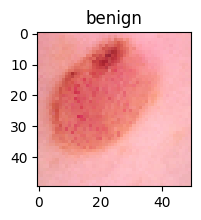

In [8]:
## Showing a randomly selected resized image
import random

# resize the image to smaller to not take up too much space
IMG_SIZE = 50
# randomly select 1 image from train set
img_path = random.choice(list(list_images(TRAIN_PATH)))
# take the class label from the folder name of the image
label = img_path.split(os.path.sep)[-2]

img = cv2.imread(img_path)
print(f"Original shape = {img.shape}")

# convert to RGB color because OpenCV still uses BGR color
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resized_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
print(f"Resized shape = {resized_img.shape}")

plt.figure(figsize=(2, 2))
plt.title(label)
plt.imshow(resized_img)
plt.show()

# Loading data using the Second Method from Training Notebook

Because there is no third split provided in the original dataset, we will split 20% of the given train data into validation set.

In [21]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_PATH,
    shuffle=True,
    # 20% is used for validation set, defined in val_ds later
    validation_split=0.2,
    subset="training",
    seed=42, # a random seed, same seed is used to replicate same results
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 2637 files belonging to 2 classes.
Using 2110 files for training.


In [22]:
CLASS_NAMES = train_ds.class_names
CLASS_NAMES

['benign', 'malignant']

In [23]:
total_train = len(train_ds.file_paths)
total_train

2110

This validation dataset `val_ds` will take the remaining data (not used for training) from `TRAIN_PATH` to use for validation, this is done by setting the same `validation_split` as we defined for `train_ds`, but a different `subset` as the parameters.

In [24]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_PATH,
    shuffle=False,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 2637 files belonging to 2 classes.
Using 527 files for validation.


In [25]:
total_val = len(val_ds.file_paths)
total_val

527

In [26]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_PATH,
    shuffle=False,
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 660 files belonging to 2 classes.


In [27]:
total_test = len(test_ds.file_paths)
total_test

660

In [28]:
## Optimize for performance, just like the previous notebook

AUTOTUNE = tf.data.AUTOTUNE
train_ds = (train_ds
            .shuffle(BATCH_SIZE * 100)
            .cache()
            .prefetch(AUTOTUNE)
)
val_ds = (val_ds
           # no shuffle
           .cache()
           .prefetch(AUTOTUNE)
)
test_ds = (test_ds
           # no shuffle
           .cache()
           .prefetch(AUTOTUNE)
)

# Preparing Pre-trained model for Transfer Learning

We will use a ResNet50 (Residual Network with 50 layers) model as our pre-trained model, you may use any pre-trained models available in the Keras Applications module that can be referred [here](https://www.tensorflow.org/api_docs/python/tf/keras/applications).

You can also read more about ResNet from a [blogpost here](https://www.mygreatlearning.com/blog/resnet/), or refer to the [official published paper](https://arxiv.org/abs/1512.03385).

For this model, we are using the Keras Functional API to build the model layers, where each layer is built in a way that's similar to calling a function, as opposed to the Sequential API that we have been using in the previous notebook.

In [17]:
# load the ResNet-50 network, ensuring the head fully connected (FC) layer sets are left
# off so that we only take the important layers from the network
print("[INFO] preparing model...")
baseModel = ResNet50(
    weights="imagenet", include_top=False, input_tensor=keras.Input(shape=(224, 224, 3))
)

[INFO] preparing model...


In [18]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
# then add extra layers to suit our choice
headModel = layers.AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = layers.Flatten(name="flatten")(headModel)
headModel = layers.Dense(256, activation="relu")(headModel)
headModel = layers.Dropout(0.5)(headModel)
# the last layer is the most important to ensure the model outputs
#  the result that we want
headModel = layers.Dense(len(CLASS_NAMES), activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = keras.Model(inputs=baseModel.input, outputs=headModel)

In [19]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process. This is the common process
# of transfer learning to make sure not to destroy the weights in the original
# pre-trained model, you may choose to unfreeze all of them later to further fine-tune
# to your custom dataset if you wish, but it is not certain whether there will be improvement
# until you have tried it
for layer in baseModel.layers:
    layer.trainable = False

# compile the model, setting a decay rate for our learning rate to 
# slowly go down during the training to improve efficiency. This is
# one way to control the updates of the model weights
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / NUM_EPOCHS)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# Training

In [29]:
# train the model
print("[INFO] Training model...")
start_time = time.perf_counter()
H = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=NUM_EPOCHS
)
end_time = time.perf_counter()
print(f"[INFO] Total time: {end_time - start_time:.2f} s")

[INFO] Training model...
Epoch 1/10
66/66 [==============================] - 21s 240ms/step - loss: 0.6071 - accuracy: 0.7265 - val_loss: 0.3393 - val_accuracy: 0.8235
Epoch 2/10
66/66 [==============================] - 14s 213ms/step - loss: 0.3929 - accuracy: 0.8166 - val_loss: 0.2515 - val_accuracy: 0.9051
Epoch 3/10
66/66 [==============================] - 14s 214ms/step - loss: 0.3512 - accuracy: 0.8393 - val_loss: 0.2371 - val_accuracy: 0.9051
Epoch 4/10
66/66 [==============================] - 14s 207ms/step - loss: 0.3046 - accuracy: 0.8659 - val_loss: 0.2407 - val_accuracy: 0.9051
Epoch 5/10
66/66 [==============================] - 13s 204ms/step - loss: 0.2882 - accuracy: 0.8583 - val_loss: 0.2183 - val_accuracy: 0.9127
Epoch 6/10
66/66 [==============================] - 14s 210ms/step - loss: 0.2651 - accuracy: 0.8758 - val_loss: 0.2398 - val_accuracy: 0.9032
Epoch 7/10
66/66 [==============================] - 14s 209ms/step - loss: 0.2545 - accuracy: 0.8839 - val_loss: 0.21

In [30]:
# serialize the model to disk
print("[INFO] saving model...")
model.save(MODEL_PATH, save_format="h5")

[INFO] saving model...


C:\Users\user\anaconda3\envs\tfod\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Total epochs: 10
Min val_loss: 0.17224 at epoch 9



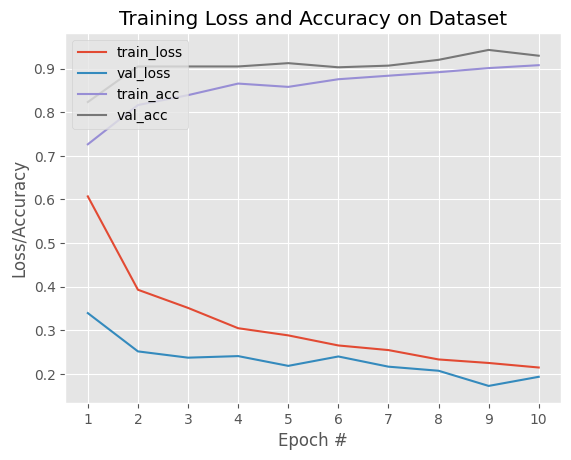

In [31]:
# plot the training and validation results
val_loss = H.history["val_loss"]
min_val_loss = np.min(val_loss)
epoch_min_val_loss = val_loss.index(min_val_loss) + 1
total_epochs = len(val_loss)
print(f"Total epochs: {total_epochs}")
print(f"Min val_loss: {min_val_loss:.5f} at epoch {epoch_min_val_loss}\n")

N = NUM_EPOCHS
plt.style.use("ggplot")
plt.xticks(np.arange(1, N + 1))
plt.plot(np.arange(1, N + 1), H.history["loss"], label="train_loss")
plt.plot(np.arange(1, N + 1), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(1, N + 1), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(1, N + 1), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
# save the figure
plt.savefig(PLOT_PATH)
plt.show()

# Evaluation

Similar to our previous notebook.

In [32]:
# Load entire saved model directly
start_time = time.perf_counter()
print(f"[INFO] Loading model ...")
model = tf.keras.models.load_model(MODEL_PATH)
end_time = time.perf_counter()
print(f"[INFO] Done. [{end_time - start_time:.2f} s]")

[INFO] Loading model ...
[INFO] Done. [1.40 s]


In [33]:
# show the accuracy on the validation set
(loss, accuracy) = model.evaluate(val_ds)
print("[INFO] Validation Accuracy: {:.2f}%".format(accuracy * 100))
(loss, accuracy) = model.evaluate(test_ds)
print("[INFO] Testing Accuracy: {:.2f}%".format(accuracy * 100))

17/17 [==============================] - 4s 159ms/step - loss: 0.1932 - accuracy: 0.9298
[INFO] Validation Accuracy: 92.98%
21/21 [==============================] - 4s 192ms/step - loss: 0.2910 - accuracy: 0.8682
[INFO] Testing Accuracy: 86.82%


In [34]:
%%time
preds = model.predict(test_ds)
preds.shape

Wall time: 3.95 s


(660, 2)

In [35]:
preds = np.argmax(preds, axis=-1)
preds.shape

(660,)

In [36]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true.shape

(660,)

In [37]:
from sklearn.metrics import classification_report

# show a nicely formatted classification report
classif_report = classification_report(
    y_true, preds, target_names=CLASS_NAMES
)
print(classif_report)
with open(CLASSIF_REPORT_PATH, "w") as f:
    f.write(classif_report)

              precision    recall  f1-score   support

      benign       0.89      0.86      0.88       360
   malignant       0.84      0.87      0.86       300

    accuracy                           0.87       660
   macro avg       0.87      0.87      0.87       660
weighted avg       0.87      0.87      0.87       660



In [44]:
np.sum(cm)

660

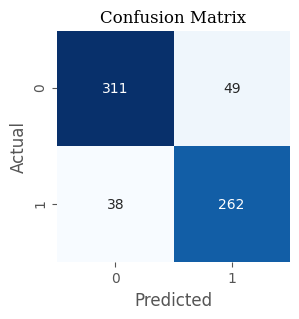

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, preds)

fig = plt.figure(figsize=(3, 3))
ax = sns.heatmap(
    cm,
    cmap="Blues",
    annot=True,
    fmt="d",
    cbar=False,
)

plt.title("Confusion Matrix", size=12, fontfamily="serif")
plt.savefig(os.path.join(OUTPUTS_PATH, "cm_skin_cancer.png"))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()